<a href="https://colab.research.google.com/github/williamdaburke/williamdaburke.github.io/blob/master/CultureTrip_Classification_grouped_rows_by_user.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
data_file_name = 'CT 2019 classification_dataset.csv'



if not os.path.exists(data_file_name):
  try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    my_drive_dir = "/content/gdrive/My Drive"
    data_dir = my_drive_dir + "/Classification Task 15-2-2019/"
  except:
    print('please add '+str(data_file_name)+' to current directory, or, if using drive to a folder called "Classification Task 15-2-2019" in your drive root.')
    data_dir = ''
else:
  data_dir = ''



import pandas as pd
from datetime import datetime
import numpy as np
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

tqdm.pandas(desc='Progress')
data_file_name = 'CT 2019 classification_dataset.csv'
data_path = data_dir + data_file_name


import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30,15]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:

def parse(x):
	return datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f')
data_df =pd.read_csv(data_path,parse_dates = ['event_time'], index_col=0, date_parser=parse).sort_values(by=['event_time'])

data_df.head()


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,event_id,domain_userid,domain_sessionid,domain_sessionidx,event,se_action,event_time,refr_medium,label
23034,1968469,19599,562700,1,struct,related_clicked,2018-04-10 00:00:00.118,search,1
23017,2234121,176120,411546,1,struct,completed_reading,2018-04-10 00:00:00.547,search,0
8049,418922,156937,7811,1,struct,scroll_start,2018-04-10 00:00:00.569,search,0
9,2552176,172947,556169,3,struct,scroll_start,2018-04-10 00:00:00.690,NaN,0
4,1781246,402150,203400,1,struct,completed_reading,2018-04-10 00:00:00.740,search,0


We can see already from these charts that search is rather important as compared to other referance mediums.  Internal as well, although, the meaning of this is more ambiguous,  as it does not tell us the user's origin.

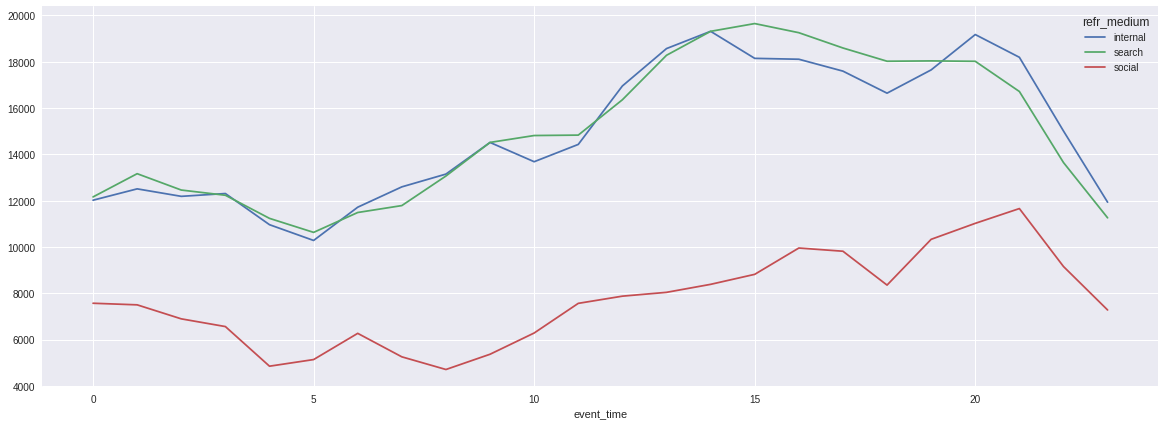

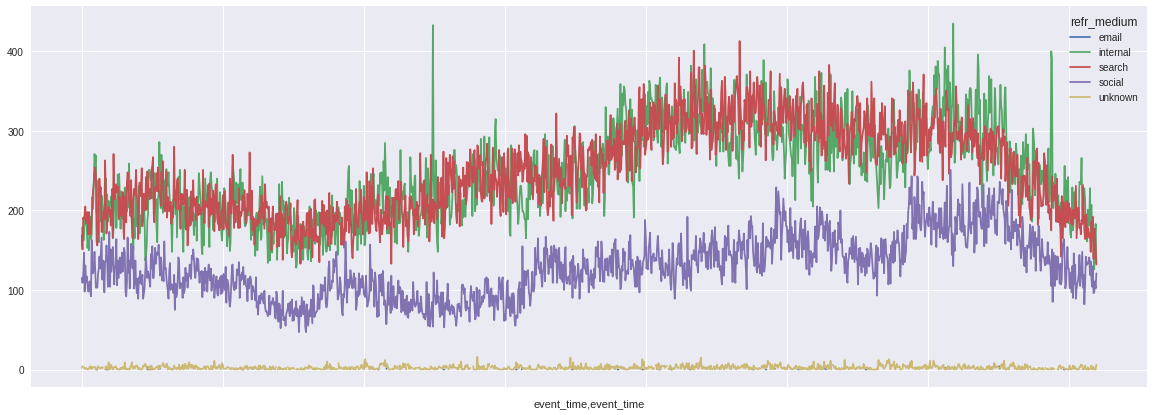

In [0]:
# plot data
fig, ax = plt.subplots(figsize=(20,7))

plt_df = data_df[~data_df['refr_medium'].isin(['unknown','email'])]
#plt_df = data_df.filter(~col('refr_medium').isin(['','email']))
# use unstack()
plt_df.groupby([plt_df['event_time'].dt.hour,'refr_medium']).sum()['label'].unstack().plot(ax=ax,label='sum')
#plt_df.groupby([data_df['event_time'].dt.hour,'refr_medium']).count()['label'].unstack().plot(ax=ax,label='count')
fig.show()

# plot data
fig, ax = plt.subplots(figsize=(20,7))
# use unstack()
data_df.groupby([data_df['event_time'].dt.hour,data_df['event_time'].dt.minute,'refr_medium']).sum()['label'].unstack().plot(ax=ax)

In [0]:
#print("\n rows not on 4-10-2018: " + str(len(data_df[~(data_df['event_time'].str.contains("2018-04-10"))])))
print('\n')
for col in data_df.columns:
  print(col,' ',data_df[col].isna().sum())

#replace event col by adding to se_action  
data_df['se_action'] = data_df['se_action'].replace(np.nan,'page_view', regex=True)
#internal and blank dont really tell us anything, so combine with unknown
data_df['refr_medium'] = data_df['refr_medium'].replace('internal','unknown', regex=True)
data_df['refr_medium'] = data_df['refr_medium'].replace(np.nan,'unknown', regex=True)

#remove all nan
#data_df = data_df.replace(np.nan, 'fill', regex=True)

data_df.shape
print("\n event")
data_df['event'].unique()
print("\n se_action")
data_df['se_action'].unique()
print("\n refr_medium")
data_df['refr_medium'].unique()
#print("\n types of dom sess idx " + str(len(data_df['domain_sessionidx'].unique())))
print("\n  	domain_sessionid")
len(data_df['domain_sessionid'].unique())
print("\n domain_sessionidx")
len(data_df['domain_sessionidx'].unique())
print("\n event_id")
len(data_df['event_id'].unique())

data_df = data_df[data_df['domain_sessionidx']==1]

#fix the one user with two session ids
data_df['domain_sessionid'][1375518] = 278146
data_df[data_df['domain_userid']==294295]
len(data_df[data_df.groupby('domain_userid')['domain_sessionid'].transform('nunique')>=2])
data_df['user_session_id'] = data_df['domain_userid'].map(str) + '_' + data_df['domain_sessionid'].map(str)




event_id   0
domain_userid   0
domain_sessionid   0
domain_sessionidx   0
event   0
se_action   962190
event_time   0
refr_medium   304576
label   0


(2632250, 9)


 event


array(['struct', 'page_view'], dtype=object)


 se_action


array(['related_clicked', 'completed_reading', 'scroll_start',
       'page_view', 'download_app_banner_closed',
       'full_screen_image_tap_on_image', 'cookie_banner_click',
       'full_screen_image_click', 'CTAShare_whatsapp',
       'child_location_click', 'newsletter_form_show',
       'top_nav_auto_complete_choose', 'video_play',
       'full_screen_image_close', 'top_nav_auto_complete_focus',
       'item_section_clicked', 'genre_article_clicked',
       'spotlight_clicked', 'CTAShare_email', 'top_bar_clicked',
       'newsletter_form_input_focused', 'video_pause',
       'top_nav_auto_complete_start_type', 'download_app_banner_clicked',
       'error', 'full_screen_image_caption_click',
       'newsletter_form_submit_clicked', 'newsletter_form_submitted',
       'newsletter_form_response_received', 'item_book_now_clicked',
       'top_nav_auto_complete_scroll', 'trending_clicked',
       'top_nav_auto_complete_click_show_more', 'go_up_clicked',
       'newsletter_form_invalid


 refr_medium


array(['search', 'unknown', 'social', 'email'], dtype=object)


  	domain_sessionid


737278


 domain_sessionidx


495


 event_id


2594921

,event_id,domain_userid,domain_sessionid,domain_sessionidx,event,se_action,event_time,refr_medium,label
1375525,1475604,294295,278146,1,page_view,page_view,2018-04-10 14:36:22,unknown,0
1375518,739539,294295,278146,1,page_view,page_view,2018-04-10 14:36:22,unknown,0


0

In [0]:
data_df['hour'] = data_df['event_time'].dt.hour
data_df['minute'] = data_df['event_time'].dt.minute

data_df['session_start'] = data_df.groupby(['user_session_id'])['event_time'].transform(np.min)
data_df['session_end'] = data_df.groupby(['user_session_id'])['event_time'].transform(np.max)

data_df['session_length'] = data_df['session_end'] - data_df['session_start']

data_df['hour_unique_user_count'] = data_df.groupby('hour')['user_session_id'].transform('nunique')
data_df['minute_unique_user_count'] = data_df.groupby(['hour','minute'])['user_session_id'].transform('nunique')

data_df['session_avg_user_per_min'] = data_df.groupby('user_session_id')['minute_unique_user_count'].transform('mean')
data_df['session_avg_user_per_hour'] = data_df.groupby('user_session_id')['hour_unique_user_count'].transform('mean')

data_df = pd.merge(data_df, data_df.groupby('user_session_id')['se_action'].apply(lambda x: (x=='page_view').sum()).reset_index(name='pages_viewed'), left_on='user_session_id', right_on='user_session_id')

data_df['count_user_events'] = data_df.groupby('user_session_id')['event_id'].transform('count')

data_df.shape
data_df.head()

(1804999, 21)

,event_id,domain_userid,domain_sessionid,domain_sessionidx,event,se_action,event_time,refr_medium,label,user_session_id,...,minute,session_start,session_end,session_length,hour_unique_user_count,minute_unique_user_count,session_avg_user_per_min,session_avg_user_per_hour,pages_viewed,count_user_events
0,1968469,19599,562700,1,struct,related_clicked,2018-04-10 00:00:00.118,search,1,19599_562700,...,0,2018-04-10 00:00:00.118,2018-04-10 00:01:51.996,00:01:51.878000,21897,620,609.5,21897.0,2,8
1,1454092,19599,562700,1,struct,scroll_start,2018-04-10 00:00:00.814,unknown,1,19599_562700,...,0,2018-04-10 00:00:00.118,2018-04-10 00:01:51.996,00:01:51.878000,21897,620,609.5,21897.0,2,8
2,2165281,19599,562700,1,page_view,page_view,2018-04-10 00:00:00.861,unknown,1,19599_562700,...,0,2018-04-10 00:00:00.118,2018-04-10 00:01:51.996,00:01:51.878000,21897,620,609.5,21897.0,2,8
3,1461235,19599,562700,1,struct,completed_reading,2018-04-10 00:00:41.999,unknown,1,19599_562700,...,0,2018-04-10 00:00:00.118,2018-04-10 00:01:51.996,00:01:51.878000,21897,620,609.5,21897.0,2,8
4,627332,19599,562700,1,struct,related_clicked,2018-04-10 00:01:01.999,unknown,1,19599_562700,...,1,2018-04-10 00:00:00.118,2018-04-10 00:01:51.996,00:01:51.878000,21897,599,609.5,21897.0,2,8


In [0]:
data_df = pd.merge(data_df, pd.crosstab(index=[data_df['user_session_id']],columns=data_df['refr_medium']), left_on='user_session_id', right_index=True).drop(['hour','minute','minute_unique_user_count','hour_unique_user_count','refr_medium','event_time','event_id','domain_sessionidx','event','domain_sessionid','domain_userid'],axis=1)

In [0]:
data_df = pd.merge(data_df, pd.crosstab(index=[data_df['user_session_id']],columns=data_df['se_action']), left_on='user_session_id', right_index=True).drop(['se_action'],axis=1)
data_df.shape

(1804999, 79)

I have manually group types of SE actions together:

 'page_view', 

'completed_reading',

'item_book_now_clicked', 'trending_clicked', 'go_up_clicked', 'footer_clicked', 'child_location_click', 'item_info_clicked',
 'item_section_clicked', 'spotlight_clicked','error', 'editors_choice_clicked', 'recommended_clicked', 
'breadcrumb_click', 'job_clicked', 'collapsible_section_clicked', 'recent_edition_click', 'LabelGenreMore_', 
 'tab_clicked', 'RelatedList_travel_61' 'related_clicked', 'scroll_start', 'top_bar_clicked', 
'genre_bar_click','genre_article_clicked',

'cookie_banner_click', 

'video_play','video_pause','video_resume',

'top_nav_auto_complete_focus','top_nav_auto_complete_choose', 'top_nav_auto_complete_start_type',
'top_nav_auto_complete_click_show_more','top_nav_auto_complete_scroll',

'app_store_click','app_store_clicked','download_app_banner_clicked','download_app_banner_closed','app_page_scroll_clicked'

'newsletter_form_show','newsletter_form_input_focused','newsletter_form_submitted','newsletter_form_invalid_email_entered',
'newsletter_form_submit_clicked','newsletter_form_response_received','newsletter_form_terms_clicked', 
'newsletter_form_privacy_clicked', 'newsletter_click_submit',



```
# This is formatted as code
```

'full_screen_image_close','full_screen_image_caption_click', // 'map_full_screen_clicked', 'full_screen_image_click', 
'full_screen_image_tap_on_image',

'map_live_mapview_clicked','map_full_screen_clicked','map_marker_clicked', 'map_item_clicked','map_directions_clicked',
'map_current_location_clicked',

'CTAShare_whatsapp','CTAShare_twitter','CTAShare_facebook','CTAShare_pinterest','CTAShare_email','CTAShare_FB',

'editor_twitter_clicked','sponsor_logo_clicked','i

In [0]:
data_df.columns

Index(['label', 'user_session_id', 'session_start', 'session_end',
       'session_length', 'session_avg_user_per_min',
       'session_avg_user_per_hour', 'pages_viewed', 'count_user_events',
       'email', 'search', 'social', 'unknown', 'CTAShare_email',
       'CTAShare_facebook', 'CTAShare_pinterest', 'CTAShare_twitter',
       'CTAShare_whatsapp', 'LabelGenreMore_', 'app_page_scroll_clicked',
       'app_store_click', 'app_store_clicked', 'breadcrumb_click',
       'child_location_click', 'collapsible_section_clicked',
       'completed_reading', 'cookie_banner_click',
       'download_app_banner_clicked', 'download_app_banner_closed',
       'editor_twitter_clicked', 'editors_choice_clicked', 'error',
       'footer_clicked', 'full_screen_image_caption_click',
       'full_screen_image_click', 'full_screen_image_close',
       'full_screen_image_tap_on_image', 'genre_article_clicked',
       'genre_bar_click', 'go_up_clicked', 'item_book_now_clicked',
       'item_caption_link',

In [0]:
data_df['video_use'] = data_df.loc[:,['video_play','video_pause','video_resume']].sum(1)
data_df['top_nav_use'] = data_df.loc[:,['top_nav_auto_complete_focus','top_nav_auto_complete_choose', 'top_nav_auto_complete_start_type','top_nav_auto_complete_click_show_more','top_nav_auto_complete_scroll']].sum(1)
data_df['newsletter_use'] = data_df.loc[:,['newsletter_form_show','newsletter_form_input_focused','newsletter_form_submitted','newsletter_form_invalid_email_entered','newsletter_form_submit_clicked','newsletter_form_response_received','newsletter_form_terms_clicked', 'newsletter_form_privacy_clicked', 'newsletter_click_submit']].sum(1)
data_df['app_use'] = data_df.loc[:,['app_store_click','app_store_clicked','download_app_banner_clicked','download_app_banner_closed','app_page_scroll_clicked']].sum(1)
data_df['full_screen_use'] = data_df.loc[:,['full_screen_image_close','full_screen_image_caption_click', 'full_screen_image_click', 'full_screen_image_tap_on_image']].sum(1)
data_df['map_use'] = data_df.loc[:,['map_live_mapview_clicked','map_full_screen_clicked','map_marker_clicked', 'map_item_clicked','map_directions_clicked','map_current_location_clicked']].sum(1)
data_df['cta_share'] = data_df.loc[:,['CTAShare_whatsapp','CTAShare_twitter','CTAShare_facebook','CTAShare_pinterest','CTAShare_email','CTAShare_FB']].sum(1)
data_df['external_link_click'] =  data_df.loc[:,['editor_twitter_clicked','sponsor_logo_clicked','item_caption_link', 'promoted_clicked','redirectionbanner_personalcontributor_show']].sum(1)
data_df['misc_clicks'] =  data_df.loc[:,['item_book_now_clicked', 'trending_clicked', 'go_up_clicked', 'footer_clicked', 'child_location_click', 'item_info_clicked','item_section_clicked', 'spotlight_clicked','error', 'editors_choice_clicked', 'recommended_clicked','breadcrumb_click', 'job_clicked', 'collapsible_section_clicked', 'recent_edition_click', 'LabelGenreMore_','tab_clicked', 'RelatedList_travel_61' 'related_clicked', 'scroll_start', 'top_bar_clicked','genre_bar_click','genre_article_clicked']].sum(1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/

In [0]:
keep_cols = ['label', 'user_session_id', 'session_start', 'session_end',
       'session_length', 'session_avg_user_per_min',
       'session_avg_user_per_hour', 'count_user_events', 'pages_viewed',
       'email', 'search', 'social', 'unknown', 'completed_reading', 
        'cookie_banner_click', 'page_view','video_use',
       'top_nav_use', 'newsletter_use', 'app_use', 'full_screen_use',
       'map_use', 'cta_share', 'external_link_click', 'misc_clicks']

data_df = data_df.drop([col for col in data_df.columns if not col in keep_cols],axis=1)


data_df.columns

Index(['label', 'user_session_id', 'session_start', 'session_end',
       'session_length', 'session_avg_user_per_min',
       'session_avg_user_per_hour', 'pages_viewed', 'count_user_events',
       'email', 'search', 'social', 'unknown', 'completed_reading',
       'cookie_banner_click', 'page_view', 'video_use', 'top_nav_use',
       'newsletter_use', 'app_use', 'full_screen_use', 'map_use', 'cta_share',
       'external_link_click', 'misc_clicks'],
      dtype='object')

In [0]:
len(data_df)
print('\n')

#reduced_df = reduced_df.drop_duplicates(keep='first')
len(data_df.drop_duplicates(keep='first'))

print('\n')

#check for double users
len(data_df['user_session_id'].unique())

assert(len(data_df.drop_duplicates(keep='first'))==len(data_df['user_session_id'].unique()))
data_df = data_df.drop_duplicates(keep='first')
#data_df.reset_index(drop=True)
#data_df = data_df.set_index('user_session_id')
data_df['session_start'] = data_df['session_start'].apply(lambda x: (x.hour*60) + x.minute)
data_df['session_end'] = data_df['session_end'].apply(lambda x: (x.hour*60) + x.minute)
data_df['session_length'] = data_df['session_length'].dt.total_seconds()
data_df = data_df.set_index('user_session_id')
data_df.head()

data_df['sess_start_sin'] = np.sin(2*np.pi*data_df['session_start']/1440)
data_df['sess_start_cos'] = np.cos(2*np.pi*data_df['session_start']/1440)

data_df['session_end_sin'] = np.sin(2*np.pi*data_df['session_end']/1440)
data_df['session_end_cos'] = np.cos(2*np.pi*data_df['session_end']/1440)
data_df = data_df.drop(['session_start','session_end'],axis=1)

1804999

507079

507079

,label,session_start,session_end,session_length,session_avg_user_per_min,session_avg_user_per_hour,pages_viewed,count_user_events,email,search,...,page_view,video_use,top_nav_use,newsletter_use,app_use,full_screen_use,map_use,cta_share,external_link_click,misc_clicks
user_session_id,,,,,,,,,,,,,,,,,,,,,
19599_562700,1,0,1,111.878,609.500000,21897.0,2,8,0,1,...,2,0,0,0,0,0,0,0.0,0.0,2.0
176120_411546,0,0,0,0.000,620.000000,21897.0,0,1,0,1,...,0,0,0,0,0,0,0,0.0,0.0,0.0
156937_7811,0,0,0,0.427,620.000000,21897.0,1,2,0,2,...,1,0,0,0,0,0,0,0.0,0.0,1.0
402150_203400,0,0,6,409.149,589.333333,21897.0,1,3,0,2,...,1,0,0,0,0,0,0,0.0,0.0,0.0
341081_493070,1,0,0,0.000,620.000000,21897.0,0,1,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0


In [0]:
#train,test = train_test_split(data_df, test_size=0.2, random_state=73)

data_train, data_test = train_test_split(data_df, test_size=0.3, random_state=73)
data_test, data_val = train_test_split(data_test, test_size=0.5)

X = data_train.drop(['label'],axis=1)
X_test  = data_test.drop(['label'],axis=1)
y = data_train['label']
y_test  = data_test['label']
X_val  = data_val.drop(['label'],axis=1)
y_val = data_val['label']



In [0]:
from sklearn.model_selection import GridSearchCV
estimator = lgb.LGBMRegressor()

# get possible parameters
estimator.get_params().keys()

# fill parameters ad libitum
param_grid = {
'objective' : ['binary'],
    'random_state' : [501],
    'num_leaves': [10,15,20,25],    
'learning_rate': [0.07, 0.1,.3],
     'n_estimators': [40,50,55],
#     'colsample_bytree' :[],
#     'min_split_gain' :[],
#     'subsample_for_bin' :[],
#     'max_depth' :[],
#     'subsample' :[], 
#     'reg_alpha' :[], 
#     'max_drop' :[], 
#     'gaussian_eta' :[], 
#     'drop_rate' :[], 
#     'silent' :[], 
#     'boosting_type' :[], 
#     'min_child_weight' :[], 
#     'skip_drop' :[], 
#     'learning_rate' :[], 
#     'fair_c' :[], 
#     'seed' :[], 
#     'poisson_max_delta_step' :[], 
#     'subsample_freq' :[], 
#     'max_bin' :[], 
#     'n_estimators' :[], 
#     'nthread' :[], 
#     'min_child_samples' :[], 
#     'huber_delta' :[], 
#     'use_missing' :[], 
#     'uniform_drop' :[], 
#     'reg_lambda' :[], 
#     'xgboost_dart_mode' :[], 
#     'objective'
}


gbm = GridSearchCV(estimator, param_grid)

'''gbm.fit(X, y)

print('\n')
print('Best parameters found by grid search are:', gbm.best_params_)'''

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

"gbm.fit(X, y)\n\nprint('\n')\nprint('Best parameters found by grid search are:', gbm.best_params_)"

In [0]:
#params = {"objective" : "regression", "metric" : "rmse", "max_depth": 12, "min_child_samples": 20, "reg_alpha": 0.1, "reg_lambda": 0.1,
#        "num_leaves" : 1024, "learning_rate" : 0.01, "subsample" : 0.9, "colsample_bytree" : 0.9, "subsample_freq ": 10}

params = {
    "objective" : "binary",
    "metric" : "rmse",
    "num_leaves" :20,  #64
    "learning_rate" : 0.1,  #.01
    "bagging_fraction" : 0.7,
    "feature_fraction" : 0.5,
    "bagging_frequency" : 6,
    "bagging_seed" : 42,
    "verbosity" : 1,
    "seed": 42,
    }

#esti 200

n_fold = 10
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
# Cleaning and defining parameters for LGBM
model = lgb.LGBMRegressor(**params, n_estimators = 50, nthread = 3, n_jobs = 3)

In [0]:
stopping = 100

prediction = np.zeros(data_test.shape[0])

for fold_n, (train_index, test_index) in enumerate(folds.split(X)):
    print('Fold:', fold_n)
    #print(f'Train samples: {len(train_index)}. Valid samples: {len(test_index)}')
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    

    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
            verbose=10, early_stopping_rounds=stopping)
    
    y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
    prediction += y_pred
prediction /= n_fold



print("mse on test set: ",mean_squared_error(y_val, model.predict(X_val)))

Fold: 0
Training until validation scores don't improve for 100 rounds.
[10]	training's rmse: 0.365512	valid_1's rmse: 0.366769
[20]	training's rmse: 0.358728	valid_1's rmse: 0.360424
[30]	training's rmse: 0.357045	valid_1's rmse: 0.358941
[40]	training's rmse: 0.356291	valid_1's rmse: 0.358361
[50]	training's rmse: 0.355987	valid_1's rmse: 0.358206
Did not meet early stopping. Best iteration is:
[50]	training's rmse: 0.355987	valid_1's rmse: 0.358206


LGBMRegressor(bagging_fraction=0.7, bagging_frequency=6, bagging_seed=42,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.5, importance_type='split', learning_rate=0.1,
       max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
       n_jobs=3, nthread=3, num_leaves=20, objective='binary',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0, verbosity=1)

Fold: 1
Training until validation scores don't improve for 100 rounds.
[10]	training's rmse: 0.36611	valid_1's rmse: 0.366643
[20]	training's rmse: 0.358503	valid_1's rmse: 0.358987
[30]	training's rmse: 0.357014	valid_1's rmse: 0.357583
[40]	training's rmse: 0.356443	valid_1's rmse: 0.3571
[50]	training's rmse: 0.356061	valid_1's rmse: 0.356831
Did not meet early stopping. Best iteration is:
[50]	training's rmse: 0.356061	valid_1's rmse: 0.356831


LGBMRegressor(bagging_fraction=0.7, bagging_frequency=6, bagging_seed=42,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.5, importance_type='split', learning_rate=0.1,
       max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
       n_jobs=3, nthread=3, num_leaves=20, objective='binary',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0, verbosity=1)

Fold: 2
Training until validation scores don't improve for 100 rounds.
[10]	training's rmse: 0.366414	valid_1's rmse: 0.364209
[20]	training's rmse: 0.358807	valid_1's rmse: 0.356536
[30]	training's rmse: 0.35733	valid_1's rmse: 0.355048
[40]	training's rmse: 0.356762	valid_1's rmse: 0.354517
[50]	training's rmse: 0.35639	valid_1's rmse: 0.354165
Did not meet early stopping. Best iteration is:
[50]	training's rmse: 0.35639	valid_1's rmse: 0.354165


LGBMRegressor(bagging_fraction=0.7, bagging_frequency=6, bagging_seed=42,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.5, importance_type='split', learning_rate=0.1,
       max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
       n_jobs=3, nthread=3, num_leaves=20, objective='binary',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0, verbosity=1)

Fold: 3
Training until validation scores don't improve for 100 rounds.
[10]	training's rmse: 0.366424	valid_1's rmse: 0.364091
[20]	training's rmse: 0.358845	valid_1's rmse: 0.35624
[30]	training's rmse: 0.357367	valid_1's rmse: 0.35477
[40]	training's rmse: 0.356797	valid_1's rmse: 0.354261
[50]	training's rmse: 0.356423	valid_1's rmse: 0.353914
Did not meet early stopping. Best iteration is:
[50]	training's rmse: 0.356423	valid_1's rmse: 0.353914


LGBMRegressor(bagging_fraction=0.7, bagging_frequency=6, bagging_seed=42,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.5, importance_type='split', learning_rate=0.1,
       max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
       n_jobs=3, nthread=3, num_leaves=20, objective='binary',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0, verbosity=1)

Fold: 4
Training until validation scores don't improve for 100 rounds.
[10]	training's rmse: 0.365872	valid_1's rmse: 0.363462
[20]	training's rmse: 0.359126	valid_1's rmse: 0.356707
[30]	training's rmse: 0.357434	valid_1's rmse: 0.355082
[40]	training's rmse: 0.356698	valid_1's rmse: 0.354433
[50]	training's rmse: 0.356413	valid_1's rmse: 0.354249
Did not meet early stopping. Best iteration is:
[50]	training's rmse: 0.356413	valid_1's rmse: 0.354249


LGBMRegressor(bagging_fraction=0.7, bagging_frequency=6, bagging_seed=42,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.5, importance_type='split', learning_rate=0.1,
       max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
       n_jobs=3, nthread=3, num_leaves=20, objective='binary',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0, verbosity=1)

Fold: 5
Training until validation scores don't improve for 100 rounds.
[10]	training's rmse: 0.366182	valid_1's rmse: 0.365982
[20]	training's rmse: 0.358563	valid_1's rmse: 0.358493
[30]	training's rmse: 0.357081	valid_1's rmse: 0.357074
[40]	training's rmse: 0.356507	valid_1's rmse: 0.356591
[50]	training's rmse: 0.356128	valid_1's rmse: 0.356312
Did not meet early stopping. Best iteration is:
[50]	training's rmse: 0.356128	valid_1's rmse: 0.356312


LGBMRegressor(bagging_fraction=0.7, bagging_frequency=6, bagging_seed=42,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.5, importance_type='split', learning_rate=0.1,
       max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
       n_jobs=3, nthread=3, num_leaves=20, objective='binary',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0, verbosity=1)

Fold: 6
Training until validation scores don't improve for 100 rounds.
[10]	training's rmse: 0.365638	valid_1's rmse: 0.365666
[20]	training's rmse: 0.358859	valid_1's rmse: 0.358865
[30]	training's rmse: 0.357182	valid_1's rmse: 0.357242
[40]	training's rmse: 0.356467	valid_1's rmse: 0.356601
[50]	training's rmse: 0.356186	valid_1's rmse: 0.356432
Did not meet early stopping. Best iteration is:
[50]	training's rmse: 0.356186	valid_1's rmse: 0.356432


LGBMRegressor(bagging_fraction=0.7, bagging_frequency=6, bagging_seed=42,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.5, importance_type='split', learning_rate=0.1,
       max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
       n_jobs=3, nthread=3, num_leaves=20, objective='binary',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0, verbosity=1)

Fold: 7
Training until validation scores don't improve for 100 rounds.
[10]	training's rmse: 0.366053	valid_1's rmse: 0.367584
[20]	training's rmse: 0.35842	valid_1's rmse: 0.35999
[30]	training's rmse: 0.356955	valid_1's rmse: 0.358606
[40]	training's rmse: 0.356377	valid_1's rmse: 0.358071
[50]	training's rmse: 0.355993	valid_1's rmse: 0.357737
Did not meet early stopping. Best iteration is:
[50]	training's rmse: 0.355993	valid_1's rmse: 0.357737


LGBMRegressor(bagging_fraction=0.7, bagging_frequency=6, bagging_seed=42,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.5, importance_type='split', learning_rate=0.1,
       max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
       n_jobs=3, nthread=3, num_leaves=20, objective='binary',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0, verbosity=1)

Fold: 8
Training until validation scores don't improve for 100 rounds.
[10]	training's rmse: 0.365301	valid_1's rmse: 0.368457
[20]	training's rmse: 0.358557	valid_1's rmse: 0.361803
[30]	training's rmse: 0.356874	valid_1's rmse: 0.360187
[40]	training's rmse: 0.356153	valid_1's rmse: 0.359591
[50]	training's rmse: 0.355847	valid_1's rmse: 0.359399
Did not meet early stopping. Best iteration is:
[50]	training's rmse: 0.355847	valid_1's rmse: 0.359399


LGBMRegressor(bagging_fraction=0.7, bagging_frequency=6, bagging_seed=42,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.5, importance_type='split', learning_rate=0.1,
       max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
       n_jobs=3, nthread=3, num_leaves=20, objective='binary',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0, verbosity=1)

Fold: 9
Training until validation scores don't improve for 100 rounds.
[10]	training's rmse: 0.365474	valid_1's rmse: 0.367225
[20]	training's rmse: 0.358732	valid_1's rmse: 0.360702
[30]	training's rmse: 0.357069	valid_1's rmse: 0.359154
[40]	training's rmse: 0.356315	valid_1's rmse: 0.358486
[50]	training's rmse: 0.355997	valid_1's rmse: 0.358268
Did not meet early stopping. Best iteration is:
[50]	training's rmse: 0.355997	valid_1's rmse: 0.358268


LGBMRegressor(bagging_fraction=0.7, bagging_frequency=6, bagging_seed=42,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.5, importance_type='split', learning_rate=0.1,
       max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
       n_jobs=3, nthread=3, num_leaves=20, objective='binary',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0, verbosity=1)

mse on test set:  0.12787948032870464


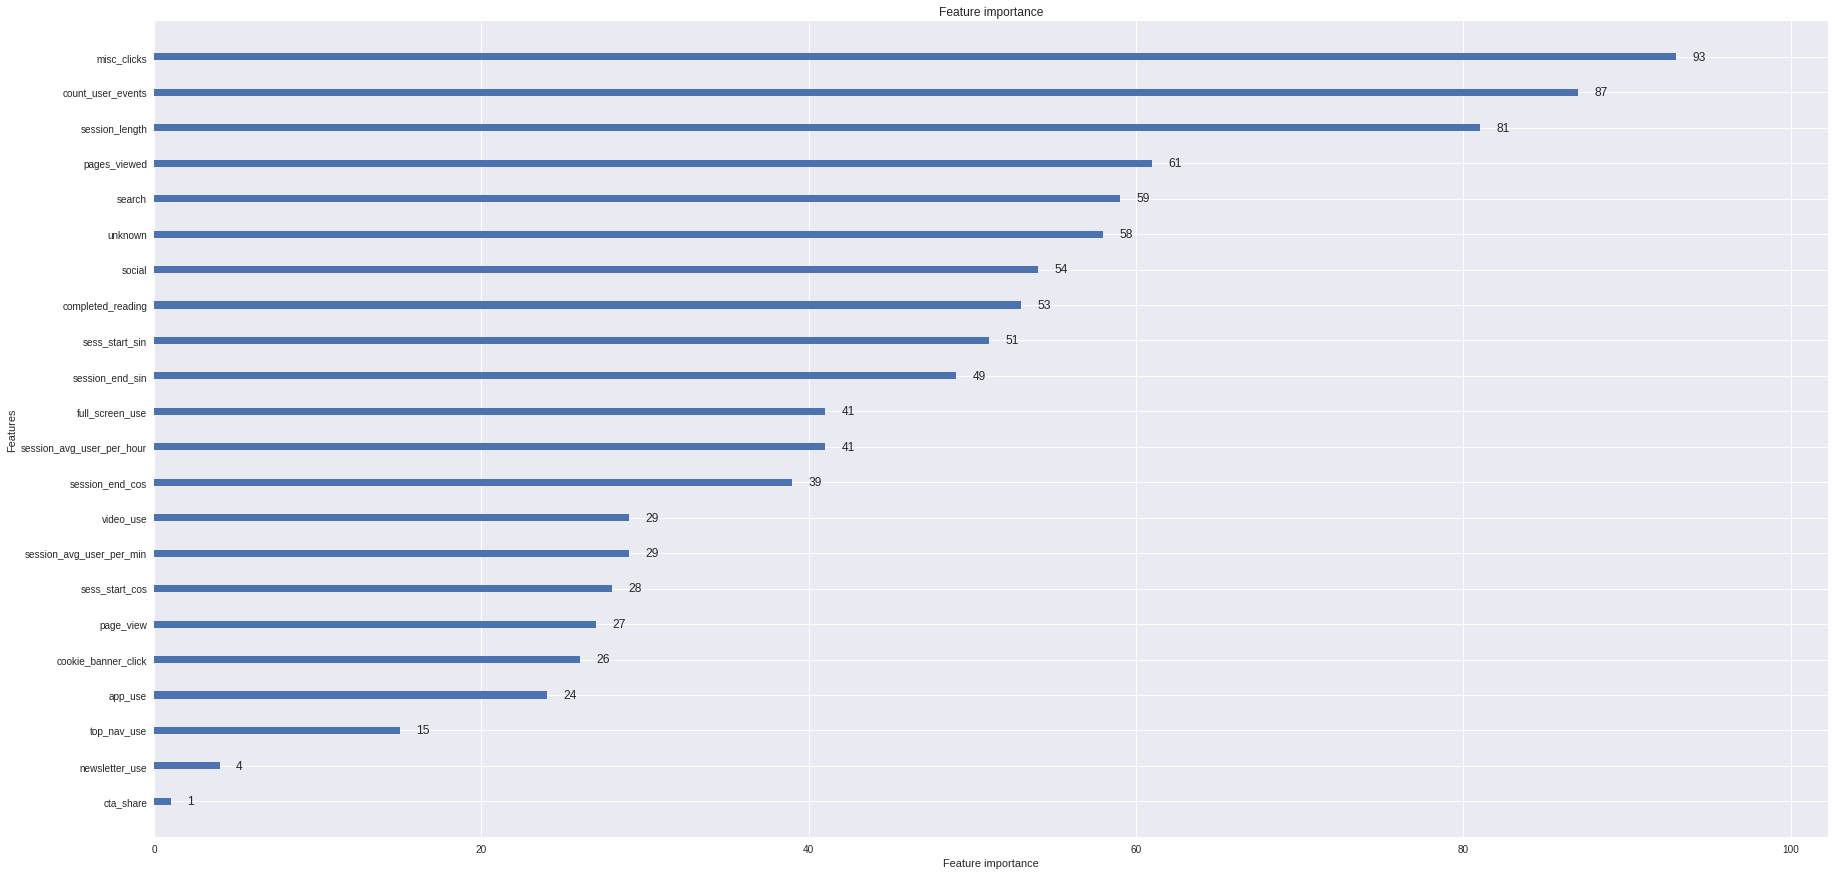

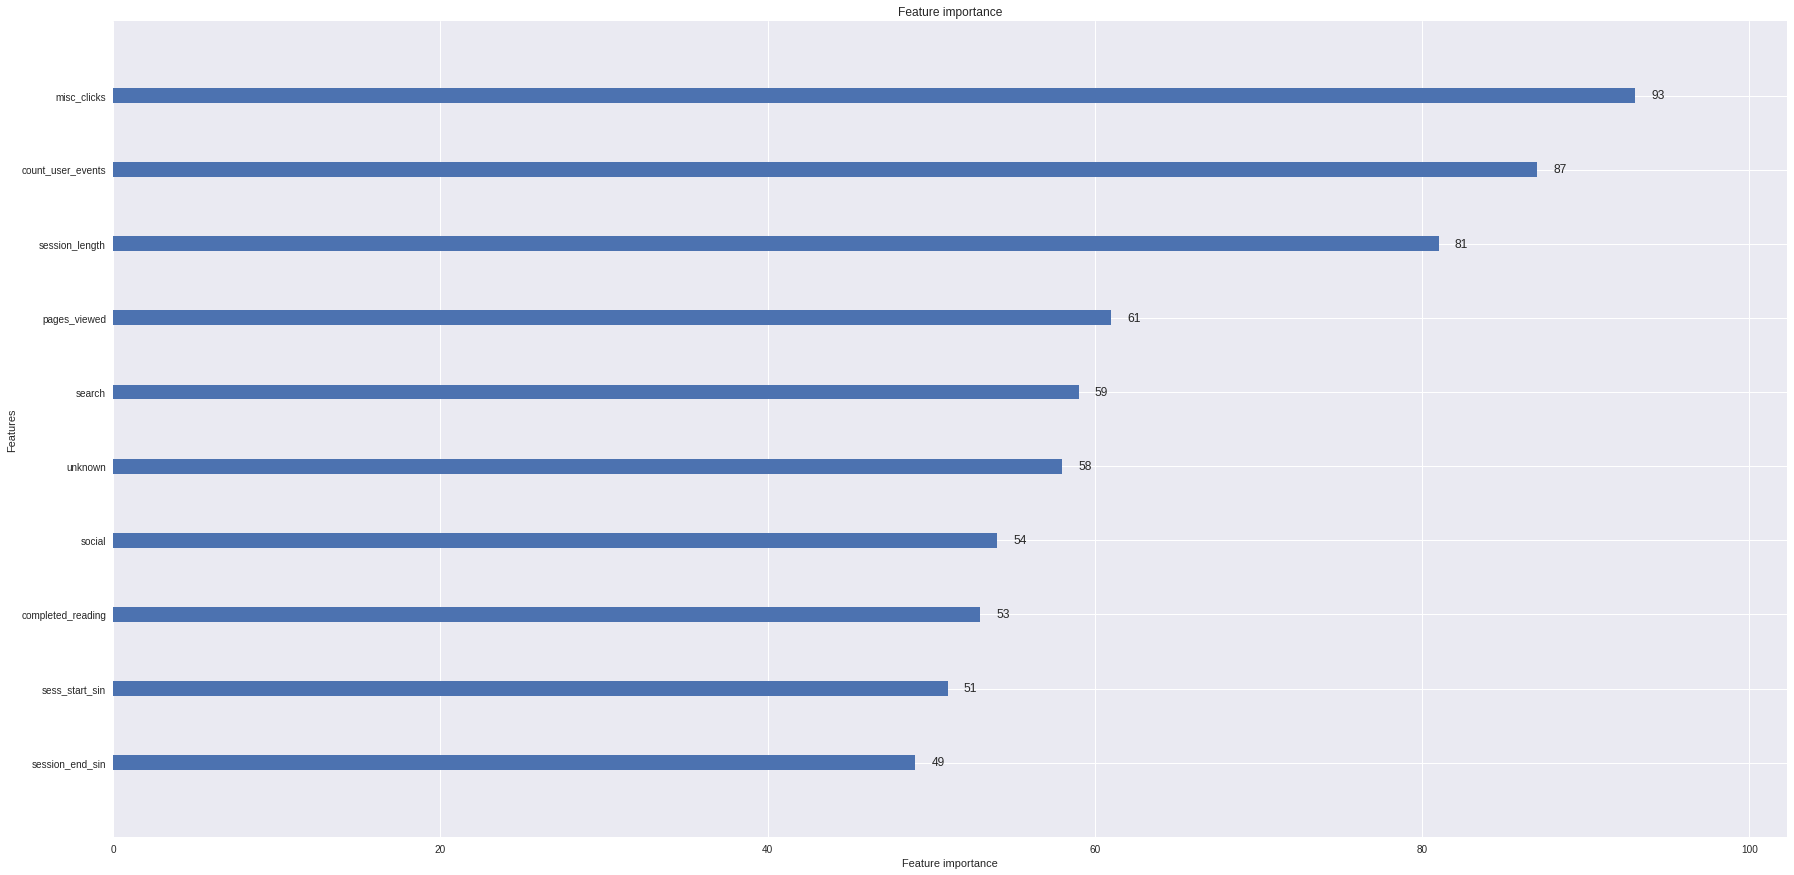

In [0]:
lgb.plot_importance(model, max_num_features=100);

lgb.plot_metric(model)
plt.rcParams['figure.figsize'] = [30,40]
lgb.plot_tree(model)

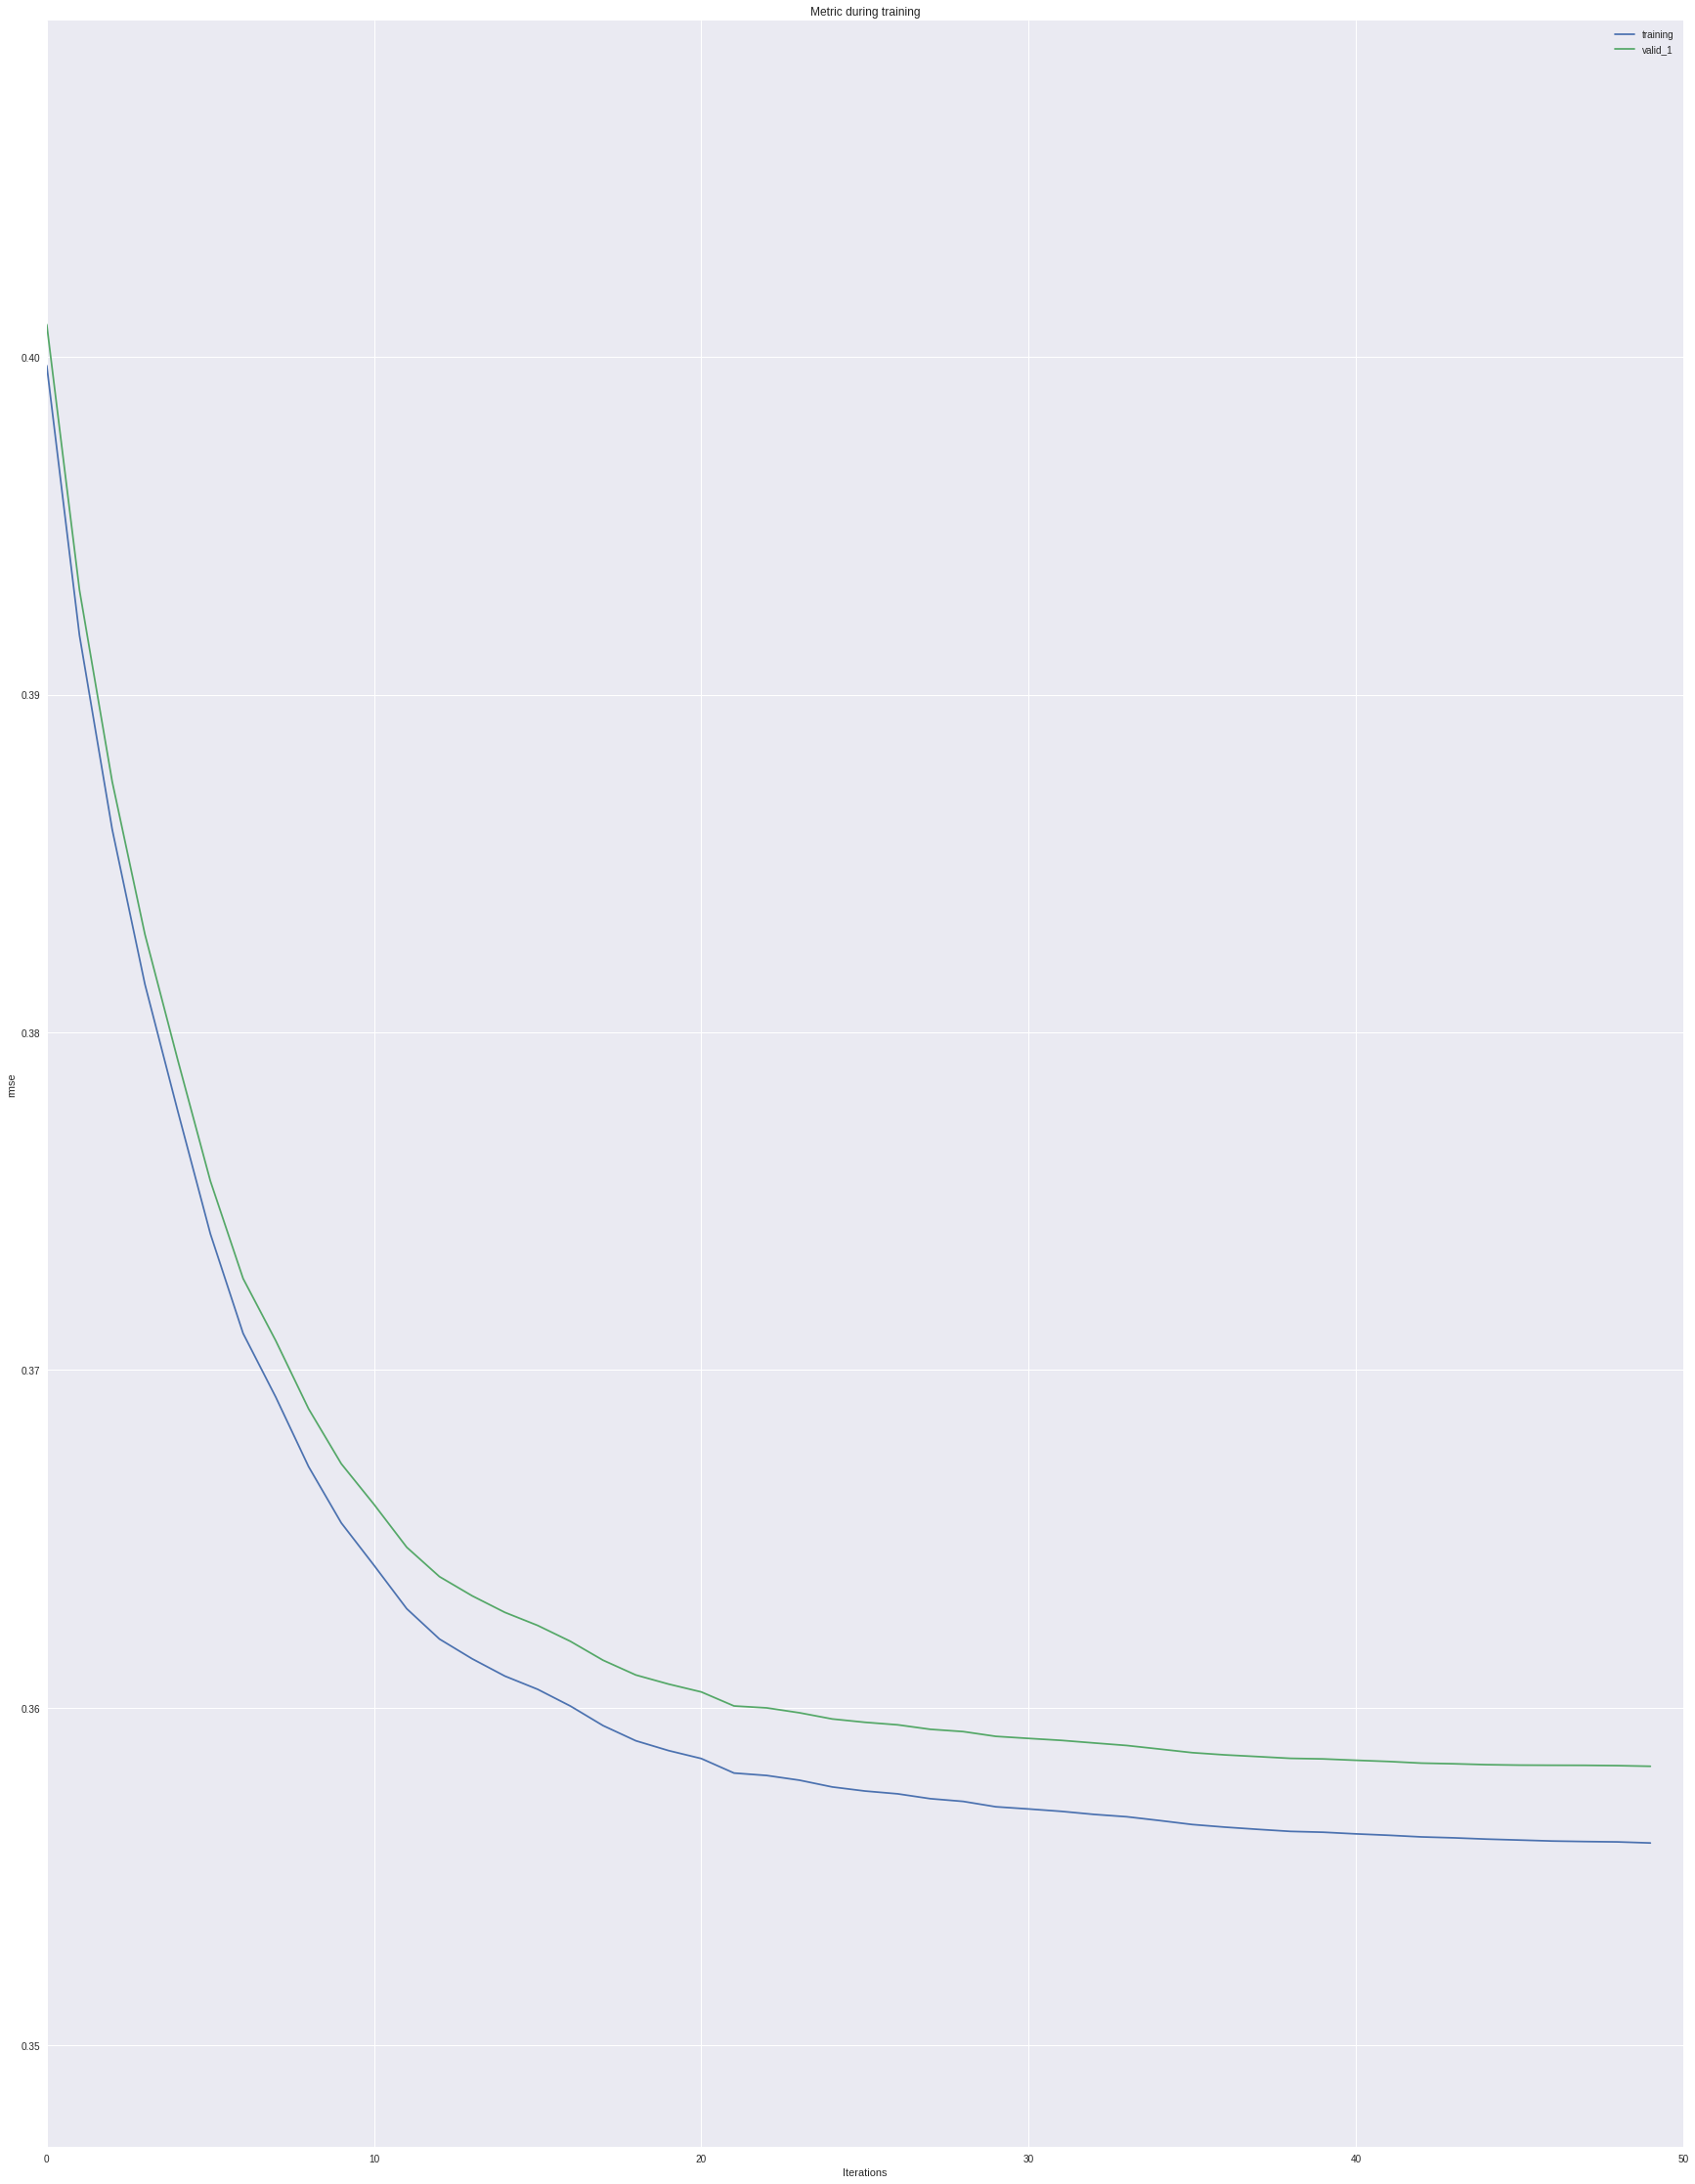

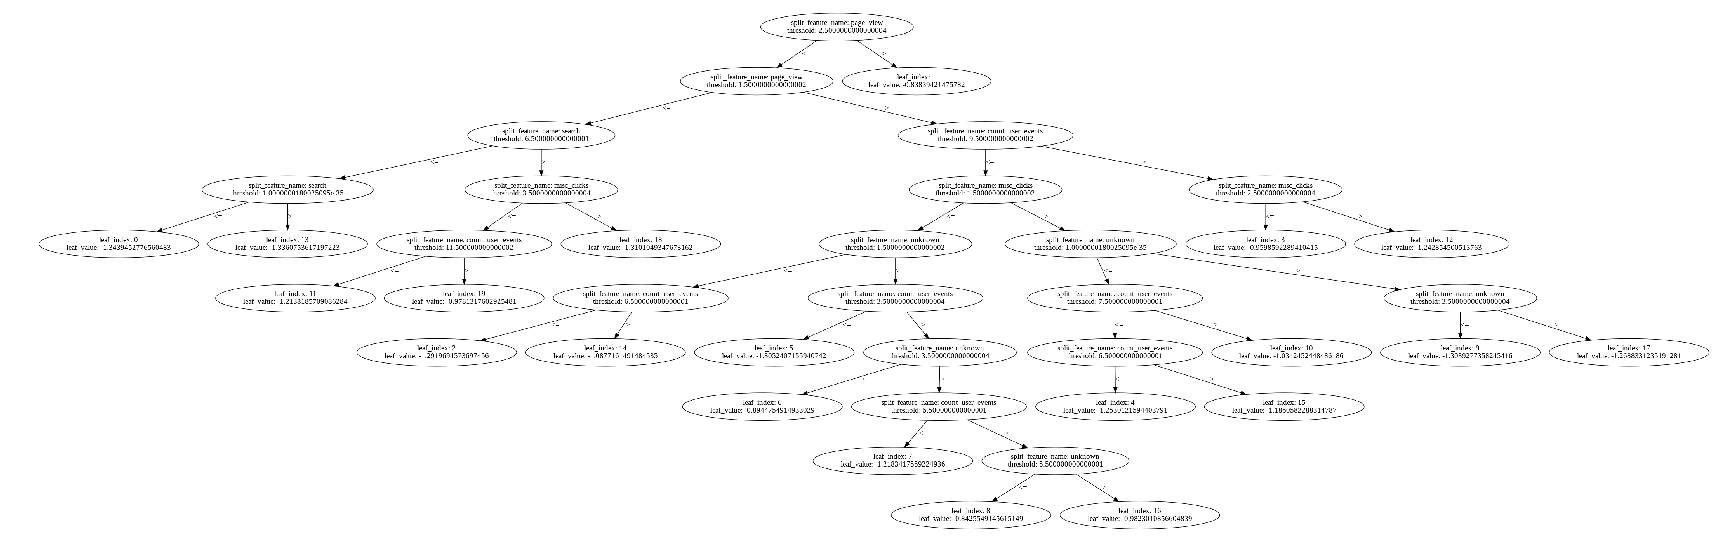

In [0]:


# Separating out the features
x = data_df.drop(['label'],axis=1).values

# Separating out the target
y = data_df.loc[:,['label']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [0]:


pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [0]:
finalDf = pd.concat([principalDf, data_df[['label']].reset_index(drop=True)], axis = 1)
finalDf.head()

,principal component 1,principal component 2,label
0,0.548174,-0.453013,1
1,-0.326820,-0.417498,0
2,-0.166241,-0.421402,0
3,-0.088680,-0.554262,0
4,-0.347606,-0.403220,1


Text(0.5, 0, 'Principal Component 1')

Text(0, 0.5, 'Principal Component 2')

Text(0.5, 1.0, '2 component PCA')

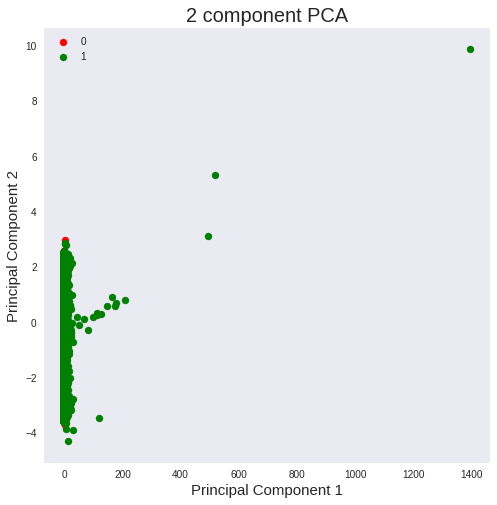

In [0]:


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()


Running PCA again ...
Explained variance: 0.3752
Individual variance contributions:
0.22169726005939927
0.153471639782254


Text(0.5, 1.0, 'Scatter plot of the training data projected on the 1st and 2nd principal components')

Text(0.5, 0, 'Principal axis 1 - Explains 22.2 % of the variance')

Text(0, 0.5, 'Principal axis 2 - Explains 15.3 % of the variance')

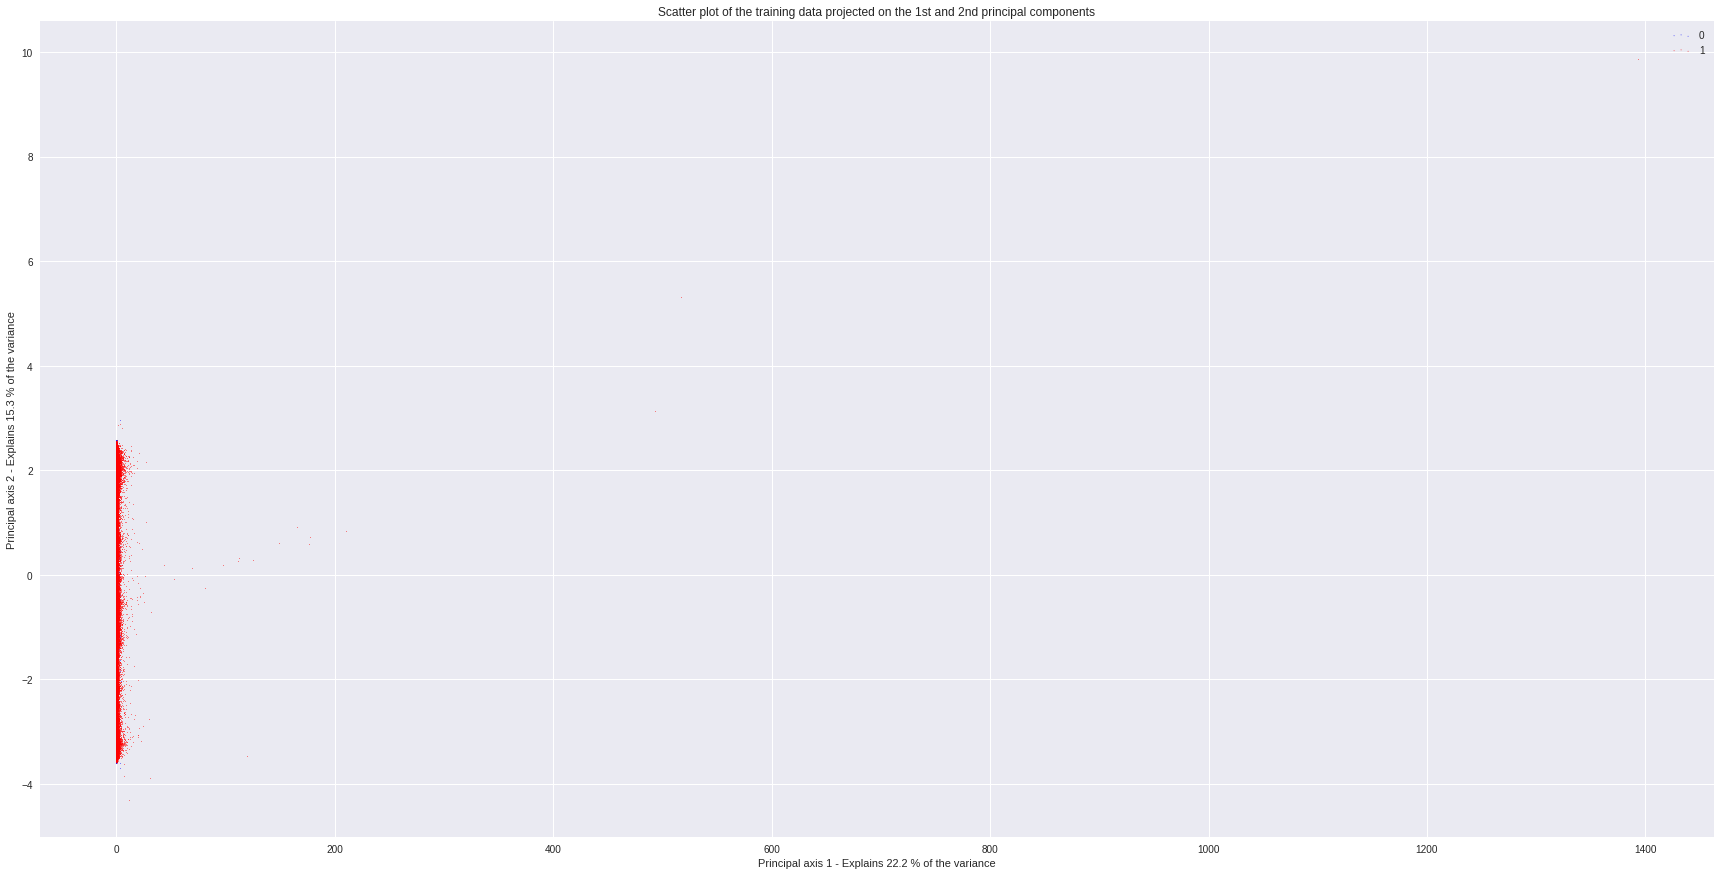

In [0]:
# Separating out the features
x = data_df.drop(['label'],axis=1).values

# Separating out the target
y = data_df['label'].values.astype(np.int8)

# Standardizing the features
x = StandardScaler().fit_transform(x)

print('\nRunning PCA again ...')


colors = ['blue', 'red']
n_comp = 2
target_names = np.unique(y)
pca = PCA(n_components=n_comp, svd_solver='full', random_state=1001)
X_pca = pca.fit_transform(x)
print('Explained variance: %.4f' % pca.explained_variance_ratio_.sum())

print('Individual variance contributions:')
for j in range(n_comp):
    print(pca.explained_variance_ratio_[j])

colors = ['blue', 'red']
plt.rcParams['figure.figsize'] = [30,15]

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], color=color, s=1,
                alpha=.8, label=target_name, marker='.')
plt.legend(loc='best', shadow=False, scatterpoints=3)
plt.title(
        "Scatter plot of the training data projected on the 1st "
        "and 2nd principal components")
plt.xlabel("Principal axis 1 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[0] * 100.0))
plt.ylabel("Principal axis 2 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[1] * 100.0))

plt.savefig('pca-porto-01.png', dpi=150)
plt.show()
    


Running PCA again ...
Explained variance: 1.0000
Individual variance contributions:
0.5662776779384779
0.3585103091946341
0.050088101390025314
0.01589279492766978
0.003433721511739471
0.003233946384748973
0.0010419205658502271
0.0006535121727991839
0.00022840562267777457
0.0002211602509988019
0.0001786719961455819
0.00010422991666491064
3.203026895861324e-05
2.380588163424132e-05
2.0337931746287948e-05
1.5082511494598244e-05
1.4543575721446136e-05
1.2356248724602983e-05
9.461066305448799e-06
5.6887405128962225e-06


Text(0.5, 1.0, 'Scatter plot of the training data projected on the 1st and 2nd principal components')

Text(0.5, 0, 'Principal axis 1 - Explains 56.6 % of the variance')

Text(0, 0.5, 'Principal axis 2 - Explains 35.9 % of the variance')

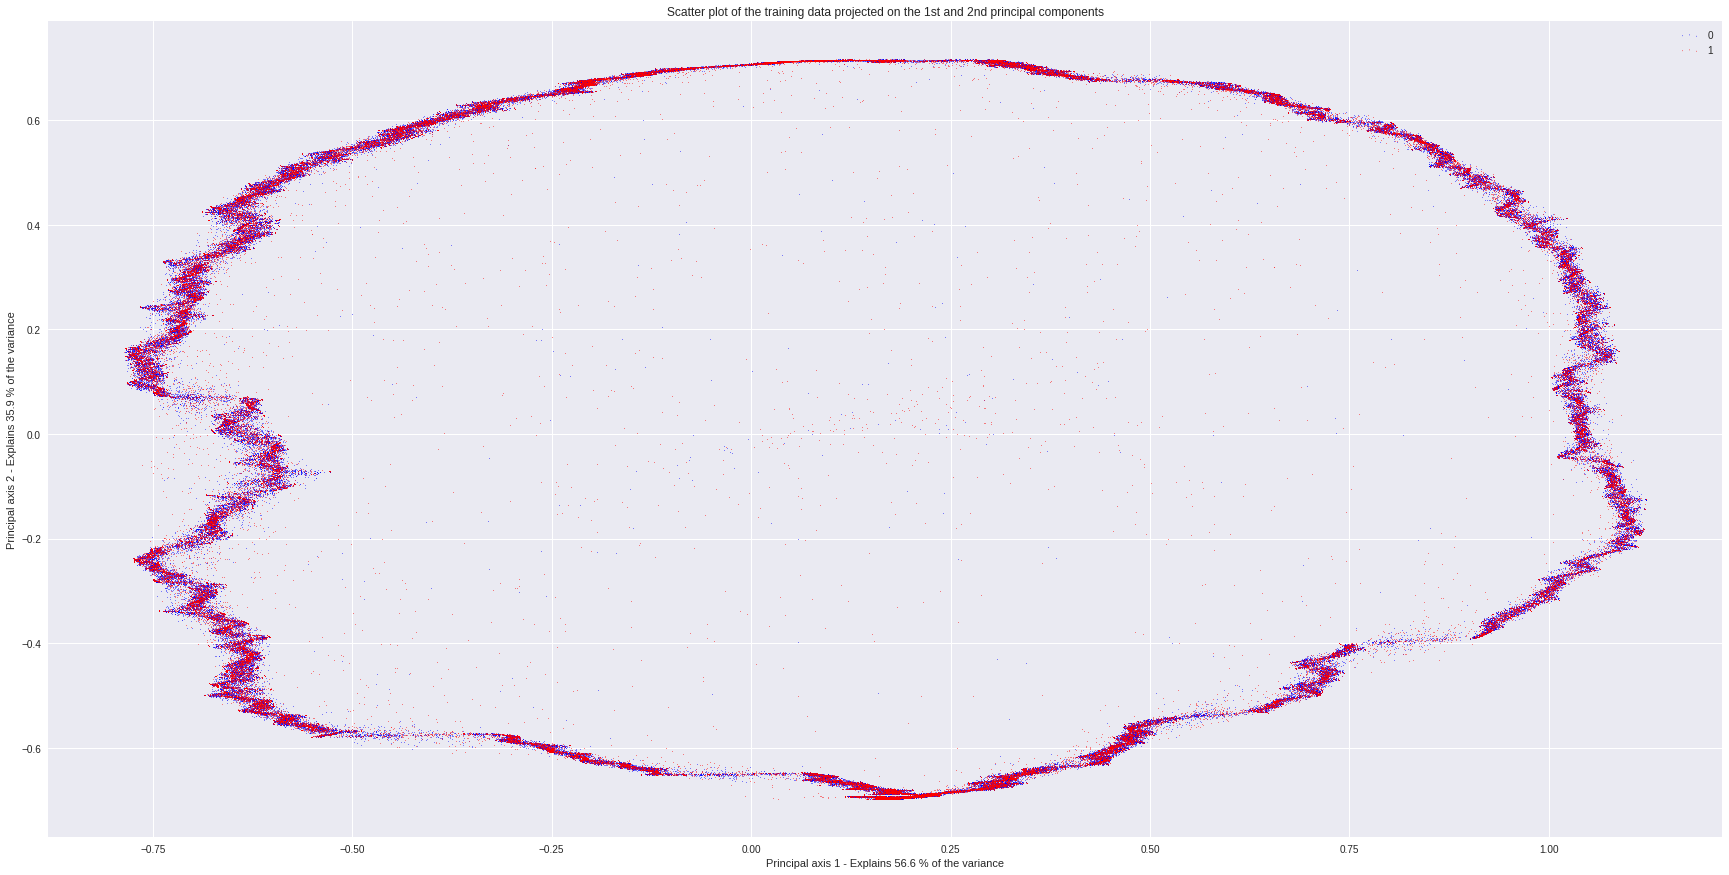

In [0]:

def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result
df_normal = normalize(data_df)

print('\nRunning PCA again ...')

y_normal = df_normal['label'].values.astype(np.int8)

colors = ['blue', 'red']
n_comp = 20
target_names = np.unique(y_normal)
pca = PCA(n_components=n_comp, svd_solver='full', random_state=1001)
X_pca = pca.fit_transform(df_normal.drop(['label'],axis=1).values)
print('Explained variance: %.4f' % pca.explained_variance_ratio_.sum())

print('Individual variance contributions:')
for j in range(n_comp):
    print(pca.explained_variance_ratio_[j])

colors = ['blue', 'red']
plt.rcParams['figure.figsize'] = [30,15]

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_pca[y_normal == i, 0], X_pca[y_normal == i, 1], color=color, s=1,
                alpha=.8, label=target_name, marker='.')
plt.legend(loc='best', shadow=False, scatterpoints=3)
plt.title(
        "Scatter plot of the training data projected on the 1st "
        "and 2nd principal components")
plt.xlabel("Principal axis 1 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[0] * 100.0))
plt.ylabel("Principal axis 2 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[1] * 100.0))

plt.savefig('pca-porto-01.png', dpi=150)
plt.show()
    

Run LightGBM again with normalised data.

In [0]:


data_train, data_test = train_test_split(df_normal, test_size=0.3, random_state=73)
data_test, data_val = train_test_split(data_test, test_size=0.5)

X = data_train.drop(['label'],axis=1)
X_test  = data_test.drop(['label'],axis=1)
y = data_train['label']
y_test  = data_test['label']
X_val  = data_val.drop(['label'],axis=1)
y_val = data_val['label']

In [0]:
stopping = 100

prediction = np.zeros(data_test.shape[0])

for fold_n, (train_index, test_index) in enumerate(folds.split(X)):
    print('Fold:', fold_n)
    #print(f'Train samples: {len(train_index)}. Valid samples: {len(test_index)}')
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    

    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
            verbose=10, early_stopping_rounds=stopping)
    
    y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
    prediction += y_pred
prediction /= n_fold



print("mse on test set: ",mean_squared_error(y_val, model.predict(X_val)))

Fold: 0
Training until validation scores don't improve for 100 rounds.
[10]	training's rmse: 0.365522	valid_1's rmse: 0.36676
[20]	training's rmse: 0.35873	valid_1's rmse: 0.360414
[30]	training's rmse: 0.357044	valid_1's rmse: 0.358945
[40]	training's rmse: 0.356292	valid_1's rmse: 0.358361
[50]	training's rmse: 0.355987	valid_1's rmse: 0.3582
Did not meet early stopping. Best iteration is:
[50]	training's rmse: 0.355987	valid_1's rmse: 0.3582


LGBMRegressor(bagging_fraction=0.7, bagging_frequency=6, bagging_seed=42,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.5, importance_type='split', learning_rate=0.1,
       max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
       n_jobs=3, nthread=3, num_leaves=20, objective='binary',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0, verbosity=1)

Fold: 1
Training until validation scores don't improve for 100 rounds.
[10]	training's rmse: 0.366114	valid_1's rmse: 0.366637
[20]	training's rmse: 0.358503	valid_1's rmse: 0.358983
[30]	training's rmse: 0.357016	valid_1's rmse: 0.357582
[40]	training's rmse: 0.356444	valid_1's rmse: 0.35709
[50]	training's rmse: 0.356061	valid_1's rmse: 0.356827
Did not meet early stopping. Best iteration is:
[50]	training's rmse: 0.356061	valid_1's rmse: 0.356827


LGBMRegressor(bagging_fraction=0.7, bagging_frequency=6, bagging_seed=42,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.5, importance_type='split', learning_rate=0.1,
       max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
       n_jobs=3, nthread=3, num_leaves=20, objective='binary',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0, verbosity=1)

Fold: 2
Training until validation scores don't improve for 100 rounds.
[10]	training's rmse: 0.366415	valid_1's rmse: 0.364206
[20]	training's rmse: 0.358808	valid_1's rmse: 0.356524
[30]	training's rmse: 0.357318	valid_1's rmse: 0.355039
[40]	training's rmse: 0.356756	valid_1's rmse: 0.354513
[50]	training's rmse: 0.356385	valid_1's rmse: 0.354187
Did not meet early stopping. Best iteration is:
[50]	training's rmse: 0.356385	valid_1's rmse: 0.354187


LGBMRegressor(bagging_fraction=0.7, bagging_frequency=6, bagging_seed=42,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.5, importance_type='split', learning_rate=0.1,
       max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
       n_jobs=3, nthread=3, num_leaves=20, objective='binary',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0, verbosity=1)

Fold: 3
Training until validation scores don't improve for 100 rounds.
[10]	training's rmse: 0.366425	valid_1's rmse: 0.364095
[20]	training's rmse: 0.358848	valid_1's rmse: 0.356243
[30]	training's rmse: 0.357367	valid_1's rmse: 0.354778
[40]	training's rmse: 0.356805	valid_1's rmse: 0.354255
[50]	training's rmse: 0.356429	valid_1's rmse: 0.35392
Did not meet early stopping. Best iteration is:
[50]	training's rmse: 0.356429	valid_1's rmse: 0.35392


LGBMRegressor(bagging_fraction=0.7, bagging_frequency=6, bagging_seed=42,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.5, importance_type='split', learning_rate=0.1,
       max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
       n_jobs=3, nthread=3, num_leaves=20, objective='binary',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0, verbosity=1)

Fold: 4
Training until validation scores don't improve for 100 rounds.
[10]	training's rmse: 0.365871	valid_1's rmse: 0.363463
[20]	training's rmse: 0.359126	valid_1's rmse: 0.356713
[30]	training's rmse: 0.357425	valid_1's rmse: 0.355078
[40]	training's rmse: 0.356694	valid_1's rmse: 0.354429
[50]	training's rmse: 0.3564	valid_1's rmse: 0.354223
Did not meet early stopping. Best iteration is:
[50]	training's rmse: 0.3564	valid_1's rmse: 0.354223


LGBMRegressor(bagging_fraction=0.7, bagging_frequency=6, bagging_seed=42,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.5, importance_type='split', learning_rate=0.1,
       max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
       n_jobs=3, nthread=3, num_leaves=20, objective='binary',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0, verbosity=1)

Fold: 5
Training until validation scores don't improve for 100 rounds.
[10]	training's rmse: 0.366182	valid_1's rmse: 0.365981
[20]	training's rmse: 0.358566	valid_1's rmse: 0.358506
[30]	training's rmse: 0.357082	valid_1's rmse: 0.357093
[40]	training's rmse: 0.356504	valid_1's rmse: 0.356613
[50]	training's rmse: 0.356121	valid_1's rmse: 0.356317
Did not meet early stopping. Best iteration is:
[50]	training's rmse: 0.356121	valid_1's rmse: 0.356317


LGBMRegressor(bagging_fraction=0.7, bagging_frequency=6, bagging_seed=42,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.5, importance_type='split', learning_rate=0.1,
       max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
       n_jobs=3, nthread=3, num_leaves=20, objective='binary',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0, verbosity=1)

Fold: 6
Training until validation scores don't improve for 100 rounds.
[10]	training's rmse: 0.36564	valid_1's rmse: 0.36566
[20]	training's rmse: 0.358855	valid_1's rmse: 0.358859
[30]	training's rmse: 0.357181	valid_1's rmse: 0.357244
[40]	training's rmse: 0.356464	valid_1's rmse: 0.356613
[50]	training's rmse: 0.356175	valid_1's rmse: 0.356431
Did not meet early stopping. Best iteration is:
[50]	training's rmse: 0.356175	valid_1's rmse: 0.356431


LGBMRegressor(bagging_fraction=0.7, bagging_frequency=6, bagging_seed=42,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.5, importance_type='split', learning_rate=0.1,
       max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
       n_jobs=3, nthread=3, num_leaves=20, objective='binary',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0, verbosity=1)

Fold: 7
Training until validation scores don't improve for 100 rounds.
[10]	training's rmse: 0.366052	valid_1's rmse: 0.367586
[20]	training's rmse: 0.358422	valid_1's rmse: 0.359992
[30]	training's rmse: 0.356949	valid_1's rmse: 0.358606
[40]	training's rmse: 0.356379	valid_1's rmse: 0.358112
[50]	training's rmse: 0.356	valid_1's rmse: 0.357799
Did not meet early stopping. Best iteration is:
[50]	training's rmse: 0.356	valid_1's rmse: 0.357799


LGBMRegressor(bagging_fraction=0.7, bagging_frequency=6, bagging_seed=42,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.5, importance_type='split', learning_rate=0.1,
       max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
       n_jobs=3, nthread=3, num_leaves=20, objective='binary',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0, verbosity=1)

Fold: 8
Training until validation scores don't improve for 100 rounds.
[10]	training's rmse: 0.365293	valid_1's rmse: 0.368453
[20]	training's rmse: 0.358559	valid_1's rmse: 0.361811
[30]	training's rmse: 0.356884	valid_1's rmse: 0.360208
[40]	training's rmse: 0.356147	valid_1's rmse: 0.359585
[50]	training's rmse: 0.355843	valid_1's rmse: 0.359371
Did not meet early stopping. Best iteration is:
[50]	training's rmse: 0.355843	valid_1's rmse: 0.359371


LGBMRegressor(bagging_fraction=0.7, bagging_frequency=6, bagging_seed=42,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.5, importance_type='split', learning_rate=0.1,
       max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
       n_jobs=3, nthread=3, num_leaves=20, objective='binary',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0, verbosity=1)

Fold: 9
Training until validation scores don't improve for 100 rounds.
[10]	training's rmse: 0.365473	valid_1's rmse: 0.367226
[20]	training's rmse: 0.358734	valid_1's rmse: 0.360717
[30]	training's rmse: 0.357033	valid_1's rmse: 0.359117
[40]	training's rmse: 0.356293	valid_1's rmse: 0.358452
[50]	training's rmse: 0.356005	valid_1's rmse: 0.358254
Did not meet early stopping. Best iteration is:
[50]	training's rmse: 0.356005	valid_1's rmse: 0.358254


LGBMRegressor(bagging_fraction=0.7, bagging_frequency=6, bagging_seed=42,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.5, importance_type='split', learning_rate=0.1,
       max_depth=-1, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
       n_jobs=3, nthread=3, num_leaves=20, objective='binary',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0, verbosity=1)

mse on test set:  0.12687305614595878


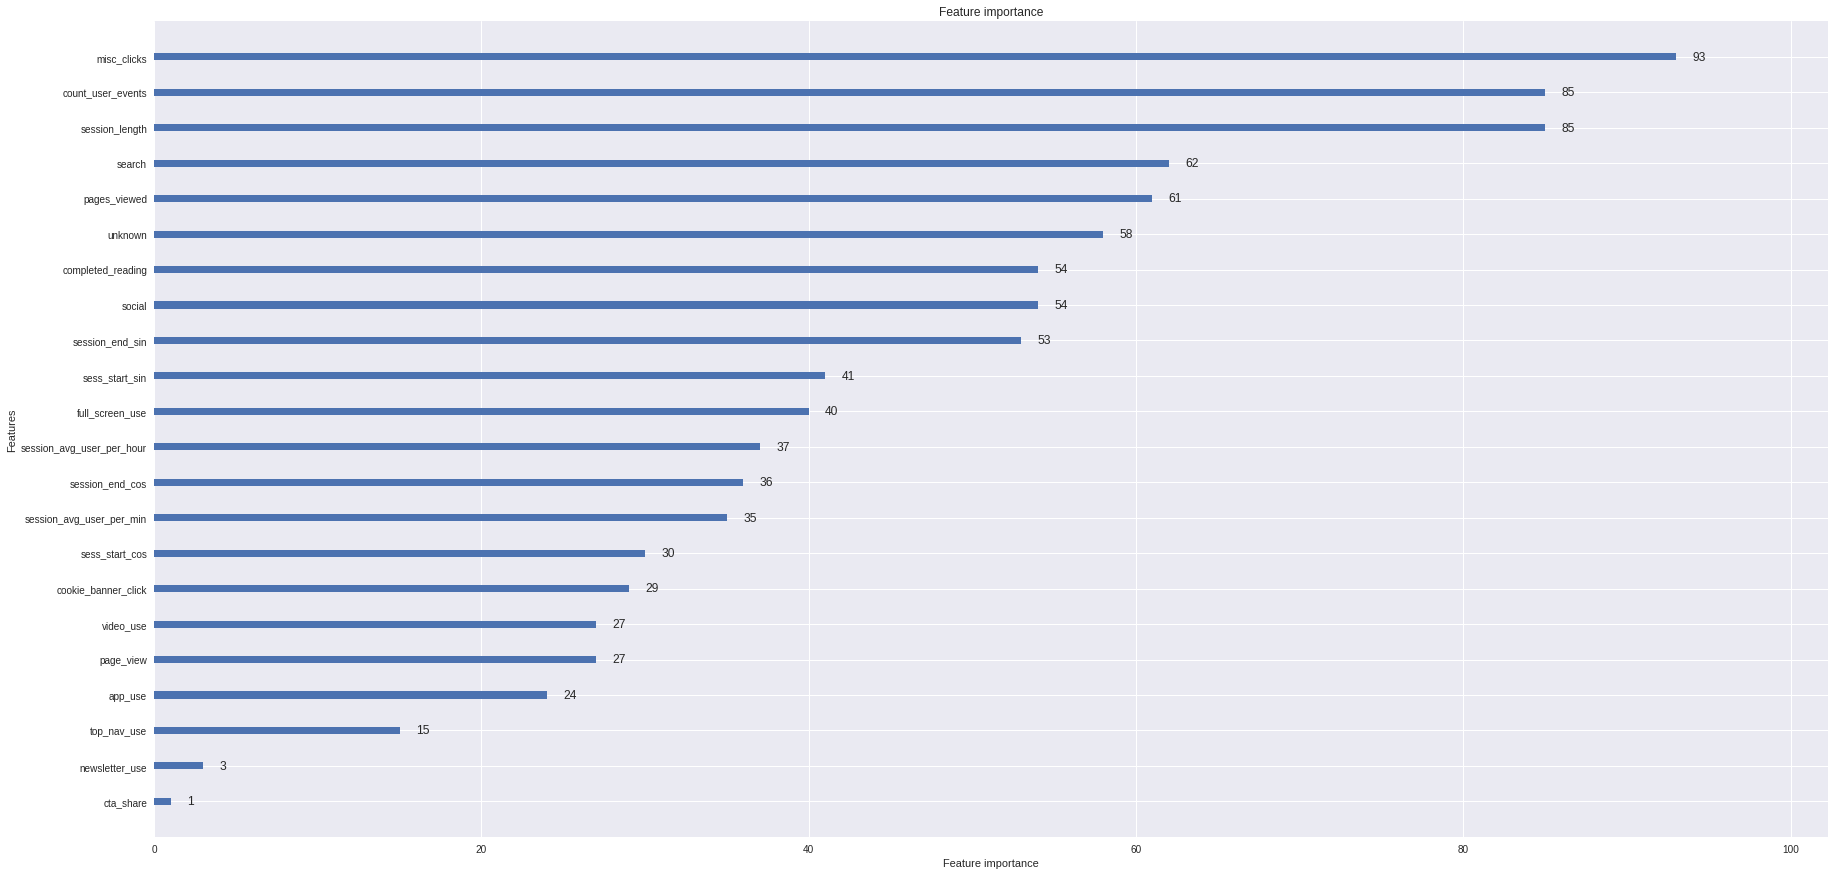

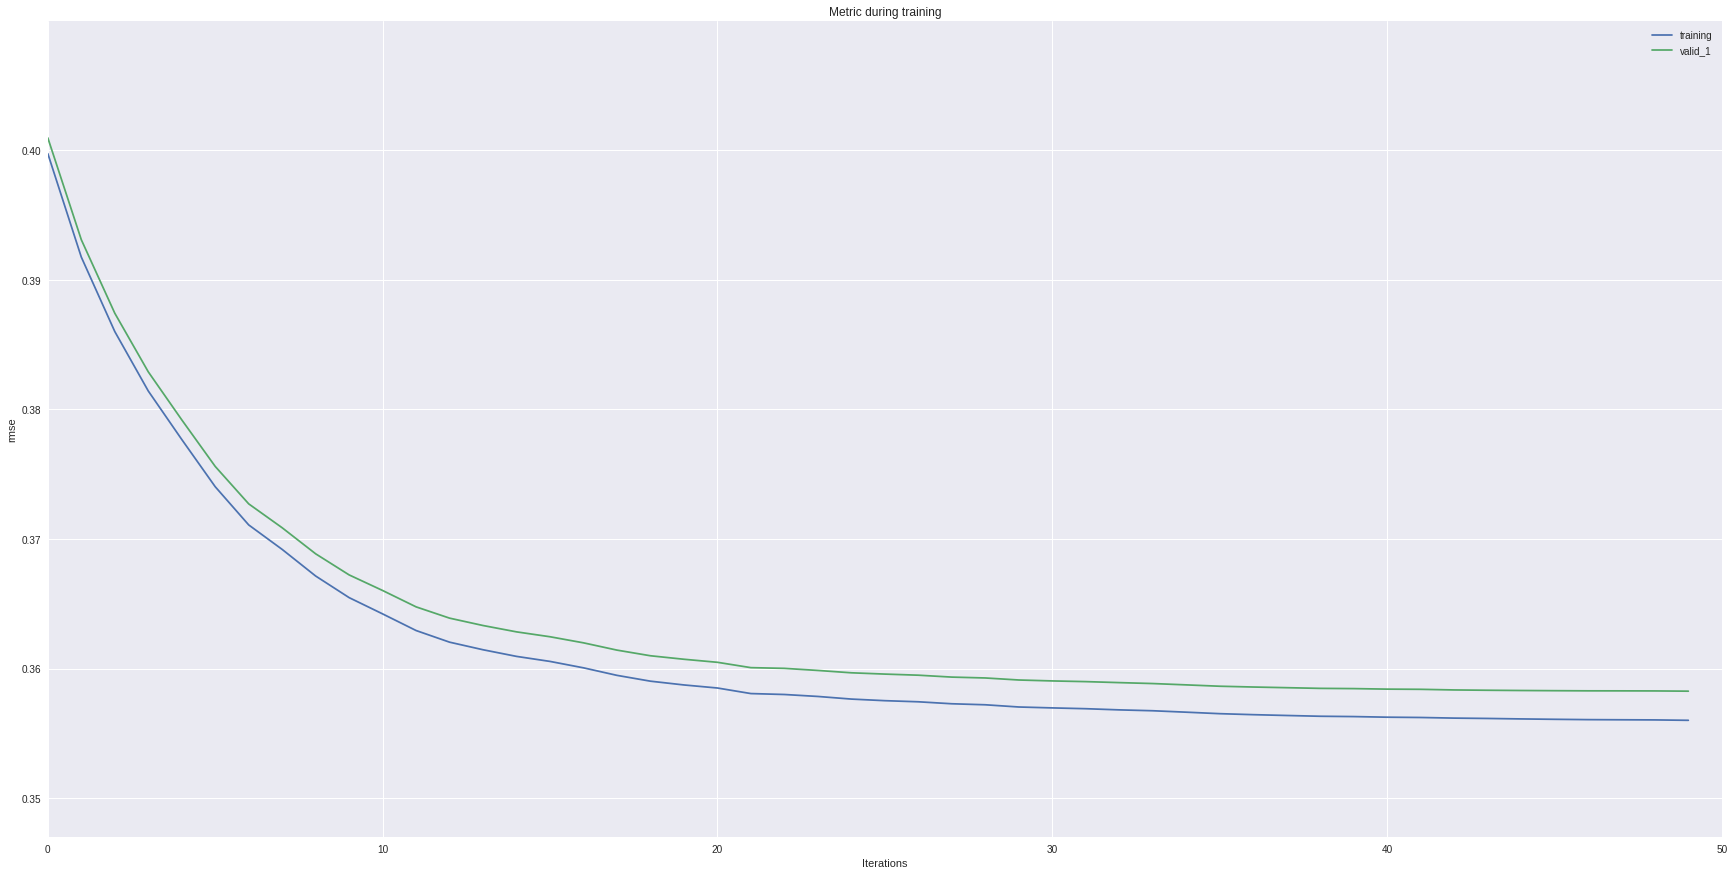

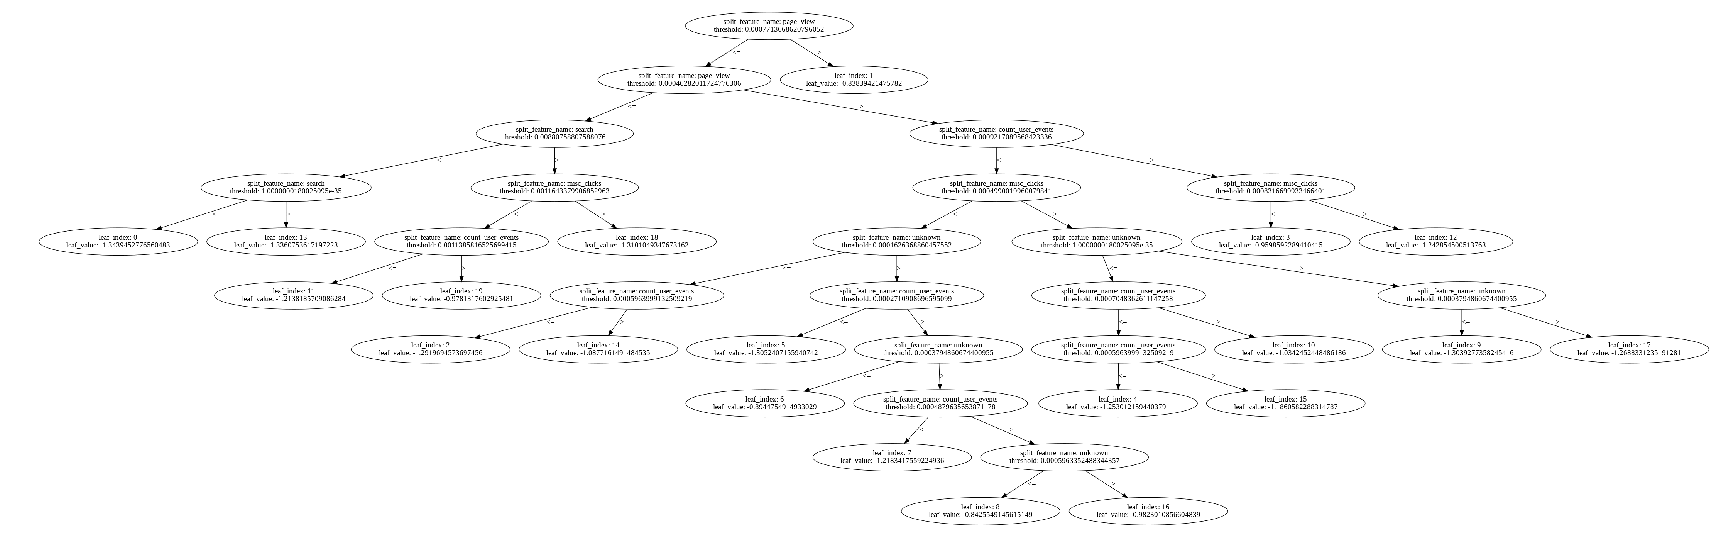

In [0]:
lgb.plot_importance(model, max_num_features=100);

lgb.plot_metric(model)
plt.rcParams['figure.figsize'] = [30,40]
lgb.plot_tree(model)